## Deezer playlist dataset et recomandandation de morceaux avec word2vec

Dans ce mini projet nous allons mettre au point un réseau word2vec et nous en servir pour construire un outils de complétion de playlist (suggestion de morceaux). Les données sont hébergée sur le dépot suivant : http://github.com/comeetie/deezerplay.git. Pour en savoir plus sur word2vec et les données que nous allons utiliser vous pouvez lire les deux références sivantes :

- Efficient estimation of word representations in vector space, Tomas Mikolov, Kai Chen, Greg Corrado, and Jeffrey Dean. (https://arxiv.org/abs/1301.3781)
- Word2vec applied to Recommendation: Hyperparameters Matter, H. Caselles-Dupré, F. Lesaint and J. Royo-Letelier. (https://arxiv.org/pdf/1804.04212.pdf)

Les éléments que vous devez réaliser sont mis en évidence en <span style="color:red">rouge</span> 


### Préparation des données
Les données sont sous la forme d'une liste de playlist. Chaque playlist est elle me une liste avec l'identifiant deezer du morçeau suivi de l'identifiant de l'artiste.

In [1]:
# chargement des données de playlist
import numpy as np
data = np.load("./Deezerplay-master/music_2.npy",allow_pickle=True)
[len(data), np.mean([len(p) for p in data])]

[100000, 24.21338]

Le jeu de données sur lequel nous allons trvailler contient 100000 playlist qui sont composeer d'en moyenne 24.1 morceaux. Nous allons commencer par ne conserver que les identifiants de morceau. 

In [2]:
# separation des ids de morçeau et d'artist
playlist_track = [list(filter(lambda w: w.split("_")[0]==u"track",playlist)) for playlist in data]
playlist_artist = [list(filter(lambda w: w.split("_")[0]==u"artist",playlist)) for playlist in data]

In [3]:
playlist_track

[['track_3248376',
  'track_68116150',
  'track_68116150',
  'track_3169189',
  'track_6523608',
  'track_407020492',
  'track_6523613',
  'track_348627211',
  'track_348627221',
  'track_348627231',
  'track_348627241',
  'track_348627251',
  'track_348627261',
  'track_348627271',
  'track_348627281',
  'track_348627291'],
 ['track_354917971',
  'track_354917981',
  'track_354917991',
  'track_354918001',
  'track_354918011',
  'track_405992352',
  'track_383552261',
  'track_397746652',
  'track_385499681',
  'track_402932992',
  'track_398786652',
  'track_357037431',
  'track_378113751',
  'track_354918011',
  'track_403520542',
  'track_393157072',
  'track_354165291',
  'track_357083271',
  'track_361171651',
  'track_145501426',
  'track_397141342',
  'track_145370202'],
 ['track_632216',
  'track_632222',
  'track_632224',
  'track_131150472',
  'track_131150474',
  'track_131150476'],
 ['track_143783500',
  'track_353166711',
  'track_403074632',
  'track_350428781',
  'track

In [4]:
# nombre de morceaux != ?
tracks = np.unique(np.concatenate(playlist_track))
Vt = len(tracks)
Vt

338509

In [5]:
tracks

array(['track_100001352', 'track_100001490', 'track_100001878', ...,
       'track_99986978', 'track_99993066', 'track_999941'], dtype='<U15')

Le nombre de morceaux différents dans ce data-set est assez élevé avec plus de 300 000 morceaux.

### Création d'un dictionnnaire de morceau
Nous allons affecter a chaque morceau un entier qui nous servira d'identifiant unique et d'entrée pour notre réseau. Pour économiser un peu nos ressources nous allons travailler dans ce TP que sur les morceaux qui apparaissent dans au moins deux playlists.

In [6]:
# nombre d'occurence de chaque morceaux ?
track_counts = dict((tracks[i],0) for i in range(0, Vt))
for p in playlist_track:
    for a in p:
        track_counts[a]=track_counts[a]+1;

In [7]:
track_counts

{'track_100001352': 1,
 'track_100001490': 1,
 'track_100001878': 1,
 'track_100001884': 12,
 'track_100004586': 16,
 'track_100004588': 14,
 'track_100004590': 219,
 'track_100004592': 13,
 'track_100004594': 13,
 'track_100004596': 10,
 'track_100004598': 10,
 'track_100004600': 14,
 'track_100004604': 14,
 'track_100004606': 7,
 'track_100004608': 6,
 'track_1000125': 7,
 'track_1000137': 1,
 'track_10001479': 1,
 'track_10001673': 1,
 'track_10001677': 1,
 'track_10001947': 1,
 'track_10001948': 1,
 'track_10001955': 1,
 'track_100023522': 1,
 'track_100025338': 2,
 'track_100028630': 1,
 'track_100028648': 1,
 'track_10002924': 6,
 'track_1000312': 1,
 'track_100031896': 10,
 'track_1000323': 1,
 'track_1000324': 1,
 'track_1000327': 1,
 'track_1000329': 1,
 'track_1000332': 1,
 'track_1000333': 1,
 'track_1000335': 1,
 'track_1000337': 1,
 'track_1000340': 1,
 'track_1000349': 1,
 'track_1000364': 1,
 'track_1000368': 1,
 'track_1000371': 1,
 'track_1000373': 1,
 'track_100037750

In [8]:
# Filtrage des morceaux peu fréquent pour gangner un peu de temps au vue de nos ressource en temps de calcul  
playlist_track_filter = [list(filter(lambda a : track_counts[a]> 1, playlist)) for playlist in playlist_track]
# recupération des comptage
counts  =  np.array(list(track_counts.values()))
# trie
order = np.argsort(-counts)
# création de notre liste d'identifiant deezer
tracks_list_ordered = np.array(list(track_counts.keys()))[order]
# Taille de notre vocabulaire = nombre de morçeau conservés
Vt=np.where(counts[order]==1)[0][0]
# construction d'un dict id_morceaux id [0,Vt]
track_dict = dict((tracks_list_ordered[i],i) for i in range(0, Vt))
# conversion des playlist en liste d'entier
corpus_num_track = [[track_dict[track] for track in play ] for play in playlist_track_filter]

In [9]:
track_dict

{'track_380684541': 0,
 'track_382428781': 1,
 'track_139470659': 2,
 'track_402932972': 3,
 'track_375689861': 4,
 'track_398649632': 5,
 'track_403074632': 6,
 'track_402932922': 7,
 'track_362795841': 8,
 'track_375437431': 9,
 'track_349385251': 10,
 'track_143783500': 11,
 'track_402932962': 12,
 'track_395664742': 13,
 'track_404284422': 14,
 'track_355724441': 15,
 'track_350428781': 16,
 'track_376989861': 17,
 'track_402932982': 18,
 'track_374051471': 19,
 'track_392355262': 20,
 'track_369397961': 21,
 'track_369643921': 22,
 'track_373531191': 23,
 'track_366297921': 24,
 'track_377343391': 25,
 'track_406297232': 26,
 'track_142750222': 27,
 'track_357426771': 28,
 'track_393460732': 29,
 'track_142706538': 30,
 'track_375437371': 31,
 'track_405508192': 32,
 'track_377447721': 33,
 'track_402932932': 34,
 'track_404667822': 35,
 'track_144949268': 36,
 'track_390514771': 37,
 'track_365994881': 38,
 'track_400520302': 39,
 'track_380620301': 40,
 'track_402932892': 41,
 '

### Création des ensembles d'apprentissage de test et de validation

Pour apprendre les paramètre de notre méthode nous allons conserver les $l-1$ premiers morceaux de chaque playlist (avec $l$ la longueur de la playlist) pour l'apprentissage. Pour évaluer les performances de completion de notre méthode nous conservons pour chaque playlist les deux derniers morceaux. L'objectif sera de trouver le dernier a partir de l'avant dernier. 



In [10]:
# ensemble de test et d'apprentissage
index_tst = np.random.choice(100000,20000)
index_val = np.setdiff1d(range(100000),index_tst)
# le debut de chaque playlist est conservé pour l'apprentissage
play_app  = [corpus_num_track[i][:(len(corpus_num_track[i])-1)] 
             for i in range(len(corpus_num_track)) if len(corpus_num_track[i])>1]
# les deux derniers élemnts pour le test et la validation
play_tst  = np.array([corpus_num_track[i][(len(corpus_num_track[i])-2):len(corpus_num_track[i])] 
             for i in index_tst if len(corpus_num_track[i])>3])
play_val  = np.array([corpus_num_track[i][(len(corpus_num_track[i])-2):len(corpus_num_track[i])] 
             for i in index_val if len(corpus_num_track[i])>3])[:10000]


In [11]:
# import de Keras
from keras.models import Sequential, Model
from keras.layers import Embedding, Reshape, Activation, Input, Dense,Flatten
from keras.layers.merge import Dot
from keras.utils import np_utils
from keras.preprocessing.sequence import skipgrams

Using TensorFlow backend.
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py

### hyper-paramètres de word2vec :

La méthode word2vec fait intervennir un certains nombre d'hyper paramètres. Nous allons les définirs et leurs donner des première valeurs que nous affinerons par la suite:

In [12]:
# dimension de l'espace latent
vector_dim = 30
# taille de la fenêtre de voisinage
window_width = 3
# sur-échantillonage des exemples négatifs
neg_sample = 5
# taille des mini-batch
min_batch_size = 50
# coeff pour la loi de tirage des exemple negatif
samp_coef = 0.5
# coeff pour le subsampling
sub_samp = 0.00001

In [13]:
Vt

123241

### Création des tables de probabilité de tirage (lissée) et non lissée

Pour tirer les exmples négatif nous avons besoin des fréquence lissé de chaque morceau dans notre dataset. De même pour sous échantilloner les morceaux très fréquents nous avons besoin des fréquence brutes. Nous allons calculer ces deux vecteurs.

In [14]:
# recupération des comptage
counts = np.array(list(track_counts.values()),dtype='float')[order[:Vt]]
# normalisation
st =  counts/np.sum(counts)
# lissage
st_smooth = np.power(st,samp_coef)
st_smooth = st_smooth/np.sum(st_smooth)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  import sys


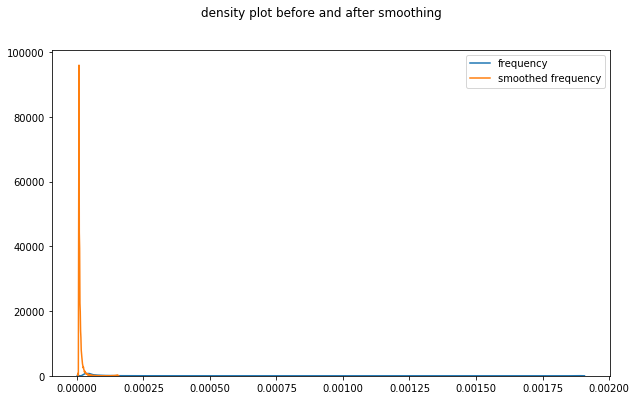

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10,6))
fig.suptitle('density plot before and after smoothing')
sns.kdeplot(st, label='frequency')
sns.kdeplot(st_smooth, label='smoothed frequency')
fig.show()

Comme montre la figure on voit bien l'effet du lissage sur la ditribution des frequences. Un α égal à 1 conduit à un échantillonnage basé sur la distribution de fréquence, un α égal à 0 rend les éléments échantillonnés égaux, tandis qu'un α négatif rend les éléments impopulaires échantillonnés plus souvent que les éléments populaires.

### Construction du réseau word2vec

Un réseau word2vec prend en entrée deux entiers correspondant à deux morceaux, ceux-ci sont plonger dans un espace latent de dimension (vector_dim) grâce a une couche de type embedding (vous devrez utilisez la même couche pour projeter les deux morceaux). Une fois ces deux vecteurs extraits le réseau doit calculer leur produit scalaire normaliser appleler cosine distance : 

$$cos(\theta_{ij})=\frac{z_i.z_j}{||z_i||||z_j||}$$ 

Pour réaliser ce traitement vous utiliserez une couche "Dot" pour "dot product". Le modèle utilise ensuite une couche de type sigmoid pour produire la sortie. Cette sortie vaudra 0 lorsque les deux morceaux sont des morceaux tirés aléatoirement dans l'ensemble du jeu de donnée et 1 lorsqu'il aurront était extraits de la même playslist. <span style="color:red">A vous de créer le modèle keras Track2Vec correspondant à cette architecture.</span>

In [16]:
# entrée deux entier (couple de morceaux)
input_target = Input((1,), dtype='int32')
input_context = Input((1,), dtype='int32')

# prolonger les deux entrées dans un espace latent 
embedding = Embedding(Vt, vector_dim, name='embedding')
target_embedding = embedding(input_target)
context_embedding = embedding(input_context)

# Couche pour calculer cosine distance
dot_product = Flatten()(Dot(axes=2)([target_embedding,context_embedding]))

# a vous de compléter
output = Dense(1, activation='sigmoid',name="classif")(dot_product)

# definition du modèle
Track2Vec = Model(inputs=[input_target, input_context], outputs=output)
Track2Vec.compile(loss='binary_crossentropy', optimizer='adam',metrics=["accuracy"])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [17]:
Track2Vec.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 30)        3697230     input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
dot_1 (Dot)                     (None, 1, 1)         0           embedding[0][0]            

### Création du générateur de données

Pour apprendre la couche de projection au coeur de notre modèle nous allons construire une générateur d'exemples positifs et négatifs de pair de morceaux proche ou aléatoires issues de nos données d'entrainement. La fonction suivante va permettre de générer de tels exemples a partir d'une playlist (seq) fournies en entrées. Cette fonction va tout d'abord construire tout les couples de morceau pouvant être extraient de la séquences s'ils se situent à moins de (windows) disance l'un de l'autres. Ces paires constitueront les paires positives. Les paires concernant deux morceaux très fréquents seront supprimer avec une probabilité qui dépendra de leur fréquences. Enfin un nombre d'exemple négatifs (correpondant neg_samples * nombre d'exemple positif) vont être tirés aléatoirement en utilisant la table de tirage (neg_sampling_table). 

In [18]:
# fonction générant les données associé a une séquence
# seq : séquence d'entrée
# neg_samples : nombre d'exemple négatif générés par example positif
# neg_sampling_table : probabilité de tirage des exemples négatif
# sub sampling_table : probabilité servant a sous échantilloner
# sub_t : paramètre de sous échantillonage
def word2vecSampling(seq,window,neg_samples,neg_sampling_table,sub_sampling_table,sub_t):
    # taille du vocabulaire
    V = len(neg_sampling_table)
    # créations des paires positives a partir de la séquence
    positives = skipgrams(sequence=seq, vocabulary_size=V, window_size=window,negative_samples=0)
    ppairs    = np.array(positives[0])
    # sous échantillonage
    if (ppairs.shape[0]>0):
        f = sub_sampling_table[ppairs[:,0]]
        subprob = ((f-sub_t)/f)-np.sqrt(sub_t/f)
        tokeep = (subprob<np.random.uniform(size=subprob.shape[0])) | (subprob<0)
        ppairs = ppairs[tokeep,:]
    nbneg     = ppairs.shape[0]*neg_samples
    # tirage des paires négatives
    if (nbneg > 0):
        negex     = np.random.choice(V, nbneg, p=neg_sampling_table)
        negexcontext = np.repeat(ppairs[:,0],neg_samples)
        npairs    = np.transpose(np.stack([negexcontext,negex]))
        pairs     = np.concatenate([ppairs,npairs],axis=0)
        labels    = np.concatenate([np.repeat(1,ppairs.shape[0]),np.repeat(0,nbneg)])
        perm      = np.random.permutation(len(labels))
        res = [pairs[perm,:],labels[perm]]
    else:
        res=[[],[]]
    return res

<span style="color:red">Utilisez cette fonction pour constuire un générateur "track_ns_generator" de données qui va générer des exemples positifs et négatifs à partir de "nbm" playlists tirées aléatoirement dans le jeu de données "corpus_num" fournis en entrée. </span>

In [19]:
# définition du générateur de couple de morceaux (y=0 <-> aléatoire, y=1 <-> proche dans une playlist)
import random
def track_ns_generator(corpus_num,nbm): 
    while 1:
        x1 = []
        x2 = []
        y = []
        # tirage de nbm playlist dans corpus_num
        seq = random.sample(corpus_num,nbm)
        for i in range(nbm):
            res = word2vecSampling(seq[i],window_width,neg_sample,st_smooth,st,sub_samp)
            l = [list(x) for x in zip(*res)]
            x1.extend([item[0][0] for item in l])
            x2.extend([item[0][1] for item in l])
            y.extend([item[1] for item in l])
        yield ([np.array(x1),np.array(x2)],np.array(y))

## Apprentissage 
Vous devriez maintenant être en mesure d'apprendre votre premier modèle avec le code suivant. Cela devrait durer entre 15 et 30 min.

In [56]:
hist=Track2Vec.fit(track_ns_generator(play_app,min_batch_size),steps_per_epoch = 200,epochs=60)

Epoch 1/60
200/200 [==============================] - 24s 120ms/step - loss: 0.6621 - accuracy: 0.8302
Epoch 2/60
200/200 [==============================] - 24s 121ms/step - loss: 0.6086 - accuracy: 0.8333
Epoch 3/60
200/200 [==============================] - 25s 124ms/step - loss: 0.5666 - accuracy: 0.8334
Epoch 4/60
200/200 [==============================] - 27s 134ms/step - loss: 0.5333 - accuracy: 0.8337
Epoch 5/60
200/200 [==============================] - 27s 135ms/step - loss: 0.5054 - accuracy: 0.8352
Epoch 6/60
200/200 [==============================] - 27s 135ms/step - loss: 0.4805 - accuracy: 0.8385
Epoch 7/60
200/200 [==============================] - 28s 139ms/step - loss: 0.4587 - accuracy: 0.8426
Epoch 8/60
200/200 [==============================] - 34s 170ms/step - loss: 0.4381 - accuracy: 0.8469s - loss: 0.4383 - accura
Epoch 9/60
200/200 [==============================] - 42s 210ms/step - loss: 0.4212 - accuracy: 0.8501
Epoch 10/60
200/200 [===========================

## Sauvegarde de l'espace latent
Nous pouvons une fois l'apprentissage effectué sauvegarder la position des morceaux dans l'espace latent avec le code suivant:

In [57]:
# récupérations des positions des morceaux dans l'espace de projection
vectors_tracks = Track2Vec.get_weights()[0]
with open('latent_positions.npy', 'wb') as f:
    np.save(f, vectors_tracks)

Et nous pouvons la recharger avec le code suivant :

In [20]:
vectors_tracks=np.load("latent_positions.npy")

In [21]:
vectors_tracks[1,:].reshape(-1,1)

array([[-0.2340188 ],
       [ 0.33920205],
       [-0.13938929],
       [ 0.14054716],
       [-0.35744768],
       [-0.23424737],
       [ 0.1749723 ],
       [-0.21099822],
       [-0.2126465 ],
       [ 0.33179104],
       [-0.36702874],
       [ 0.2831882 ],
       [ 0.17213966],
       [ 0.37147737],
       [-0.18321538],
       [ 0.07197958],
       [ 0.21036965],
       [ 0.05062316],
       [ 0.09030619],
       [ 0.24376237],
       [ 0.1425464 ],
       [ 0.03358848],
       [-0.13357769],
       [ 0.20585614],
       [ 0.22214736],
       [-0.5331134 ],
       [-0.08253517],
       [-0.08188801],
       [-0.2029391 ],
       [-0.10305438]], dtype=float32)

## Utilisation en complétion et évaluation
Nous pouvons maintenant nous servir de cet espace pour faire des suggestions. <span style="color:red">Construisez une fonction predict_batch qui prend en entrée un vecteur de numéro de morceaux (seeds), (s) un nombre de proposition a faire, les vecteurs des morceaux dans l'espace latent X et un kd-tree permettant d'accélérer les calculs de plus proche voisins. Pour faire ses propisitions cette fonctions retournera les indices des s plus proche voisins de chaque seeds. </span> Pour que ces predictions ne prennent pas trop de temps vous vous servirez d'un kd-tree (disponnible dans scikit learn) pour accélrer la recherche des plus proche voisins.

In [22]:
from sklearn.neighbors import KDTree
kdt = KDTree(vectors_tracks, leaf_size=10, metric='euclidean')

In [23]:
def predict_batch(seeds,k,X,kdt):
    # créer une liste vide pour stocker les plus proches voisins pour chaque track
    rec_idx = list()
    for track in seeds:
        rec_idx.append(list(kdt.query(X[track,:].reshape(1,-1), k=k)[1][0]))
    return rec_idx

<span style="color:red">Utilisez cette fonction pour proposer des morceaux pour compléter les playlist du jeu de données de validation (les seeds correspondent à la première colone de play_val).</span>

In [122]:
indexes = predict_batch(play_val[:,0],10,vectors_tracks,kdt)

<span style="color:red">Comparez ces suggestions avec la seconde colonne de play_val (les morceaux effectivement présents). Pour cela vous calculerez le hit@10 qui vaut 1 si le morceau effectivement présent dans la playlist fait partie des 10 propositions (ce score étant moyenné sur l'ensemble de validation) et le NDCG@10 (Normalized Discounted Cumulative Gain) qui prend en compte l'ordre des propositions. Ce second score vaut $1/log2(k+1)$ si la proposition k (k entre 1 et 10) est la proposition correcte et 0 si aucne proposition n'est correcte. Comme précedement vous calulerez le score moyen sur l'ensemble de validation. </span>


In [139]:
def metrics(X):
    m1 = 0
    m2 = list()
    for i in range(len(X)):
        if play_val[i,1] in X[i]:
            m1 = m1 + 1
            m2.append(1/np.log2((X[i].index(play_val[i,1])+2)))
        else:
            m2.append(0)
    return m1/len(X), sum(m2)/len(X)

In [140]:
HitatK, NDGCatK  = metrics(indexes)
print('Le score HitatK est {}'.format(HitatK))
print('-'*50)
print('Le score NDGCatK est {}'.format(NDGCatK))

Le score HitatK est 0.1714
--------------------------------------------------
Le score NDGCatK est 0.10237375046402257


## Tunning des hyper paramètres

<span style="color:red">Vous pouvez maintenant essayer de faire varier les hyper paramètres pour améliorer vos performances. Attention au temps de calcul préparez une grille avec une dizaine de configurations différentes et évaluez chacune d'entre elles sur votre ensemblede validation.
Evaluez les performances finales de la meilleure configuration trouvée sur l'ensemble de test. N'oubliez pas de sauvergader vos résultats.</span>



On va définir une fonction *Hyper_tuning_params* qui prend en argument un dictionnaire d'hyperparamètres pour entrainer notre modèle sur chaque combinaison de ces params. Cette fonction enregistre les deux metriques HitatK et NDGCatK sur l'ensemble de test play_val et enfin on va garder les paramètres qui donnent les meilleurs résultats afin de réentrainer le modèle et enregitrer l'espace latent qui va nous servir pour effectuer les recommendations. 

La cellule ci-dessous prendra beaucoup de temps, donc on va pas lancer le hyper tuning dans une machine locale, c'est à éxecuter dans une machine virtuele avec une grande capacité de calcul (CPU, GPU).

On a testé quelques ittérations et notre fontion marche bien :D !, voici quelques captures d'écran de l'éxecution de cette céllule dans l'environnement GoogleColab qui offre la possibilité d'utiliser une machine virtuel avec un CPU. 

![Output](./proj_1.png "output hyper tuning sur GoogleColab")
![Output](./proj_2.png "output hyper tuning sur GoogleColab")


In [ ]:
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
import itertools

# Function to create model, required for KerasClassifier
def create_model(vector_dim):

    # entrée deux entier (couple de morceaux)
    input_target = Input((1,), dtype='int32')
    input_context = Input((1,), dtype='int32')

    # prolonger les deux entrées dans un espace latent 
    embedding = Embedding(Vt, vector_dim, name='embedding')
    target_embedding = embedding(input_target)
    context_embedding = embedding(input_context)

    # Couche pour calculer cosine distance
    dot_product = Flatten()(Dot(axes=2)([target_embedding,context_embedding]))

    # a vous de compléter
    output = Dense(1, activation='sigmoid',name="classif")(dot_product)

    # definition du modèle
    Track2Vec = Model(inputs=[input_target, input_context], outputs=output)
    Track2Vec.compile(loss='binary_crossentropy', optimizer='adam',metrics=["accuracy"])
  
    return Track2Vec


def track_ns_generator(corpus_num,nbm,window_width,neg_sample,st_smooth,st,sub_samp): 
    while 1:
        x1 = []
        x2 = []
        y = []
        # tirage de nbm playlist dans corpus_num
        seq = random.sample(corpus_num,nbm)
        for i in range(nbm):
            res = word2vecSampling(seq[i],window_width,neg_sample,st_smooth,st,sub_samp)
            l = [list(x) for x in zip(*res)]
            x1.extend([item[0][0] for item in l])
            x2.extend([item[0][1] for item in l])
            y.extend([item[1] for item in l])
          
        yield ([np.array(x1),np.array(x2)],np.array(y))


# fix random seed for reproducibility
seed = 7
np.random.seed(seed)


# dimension de l'espace latent
vector_dim = (30, 100, 200)
# taille de la fenêtre de voisinage
window_width = (3, 5) 
# sur-échantillonage des exemples négatifs
neg_sample = (5,10)
# taille des mini-batch
min_batch_size = (50, 100)
# coeff pour la loi de tirage des exemple negatif
samp_coef = (0.5, 0.75, 0.6)
# coeff pour le subsampling
sub_samp = (0.00001, 0.0005)

param_dict = {'min_batch_size':min_batch_size, 'vector_dim':vector_dim, 'window_width':window_width,'neg_sample':neg_sample, 'samp_coef': samp_coef, 'sub_samp':sub_samp}

def Hyper_tuning_params(param_dict):
    score_best, parm_best = 0,()
    # les tuples individuels
    min_batch_size, vector_dim, window_width, neg_sample, samp_coef, sub_samp  = [tup for k,tup in param_dict.items()] 
    # Créer toutes les combinaisons
    parm_combo =    list(itertools.product(min_batch_size, vector_dim, window_width, neg_sample, samp_coef, sub_samp)) 

    for parms in parm_combo:

        min_batch_size, vector_dim, window_width, neg_sample, samp_coef, sub_samp = parms
        # effectuer le lissage
        st_smooth = np.power(st,samp_coef)
        st_smooth = st_smooth/np.sum(st_smooth)
        # créer le model track2vec
        Track2Vec = create_model(vector_dim)
        # fit model 
        Track2Vec.fit(track_ns_generator(play_app,min_batch_size,window_width,neg_sample,st_smooth,st,sub_samp),steps_per_epoch = 50,epochs=20)
        # Garder les poids
        vectors_tracks = Track2Vec.get_weights()[0]
        # Construire KDTree qui prend les 10 plus proches voisins
        kdt = KDTree(vectors_tracks, leaf_size=10, metric='euclidean')
        # Calculer les predictions de KDTree
        indexes = predict_batch(play_val[:,0],10,vectors_tracks,kdt)
        # Calculer les métriques
        HitatK, NDGCatK  = metrics(play_val[:,1],indexes)
        # Visualiser les scores des métriques pour chaque combinaison de parms
        print('HitatK score est {}, NDGCatK score est {}, avec params {}'.format(HitatK, NDGCatK, parms))
        
        #Enregitrer le meilleur score NDGCatK
        score = NDGCatK
        if score > score_best:
            score_best = score
            parm_best = parms
    print("Best score -",score_best, "Best parms - ",parm_best)

# Run hyper tuning paramètres
Hyper_tuning_params(param_dict)

## Bonus, un peu de musique

Le fichier TrackArtists contient des méta.données sur les morceaux et les artiste pour un sous ensemble des 300000 morceaux présent dans le dataset. Nous pouvons nous en servir pour recherchez le numéro d'un morceau a partir de son titre:

In [24]:
import pandas as pd
tr_meta=pd.read_csv("./Deezerplay-master/tracks_proj.csv")
joindf = pd.DataFrame({"id":tracks_list_ordered[:Vt],"index":range(Vt)})
meta = tr_meta.merge(joindf, left_on="id",right_on="id")
meta.set_index("index",inplace=True)
meta[["title","artist_name","preview","id"]]

,title,artist_name,preview,id
index,,,,
14086,Alone,Petit Biscuit,http://cdn-preview-8.deezer.com/stream/c-89176...,track_100001884
9768,It Was Always You,Maroon 5,http://cdn-preview-e.deezer.com/stream/c-e24ca...,track_100004586
11888,Unkiss Me,Maroon 5,http://cdn-preview-4.deezer.com/stream/c-42340...,track_100004588
321,Sugar,Maroon 5,http://cdn-preview-b.deezer.com/stream/c-b3342...,track_100004590
12477,Leaving California,Maroon 5,http://cdn-preview-5.deezer.com/stream/c-53dbb...,track_100004592
...,...,...,...,...
5338,Hometown,Twenty One Pilots,http://cdn-preview-2.deezer.com/stream/c-2d107...,track_99976972
9202,Not Today,Twenty One Pilots,http://cdn-preview-9.deezer.com/stream/c-9d2b0...,track_99976974
8386,Goner,Twenty One Pilots,http://cdn-preview-2.deezer.com/stream/c-242d7...,track_99976976


In [25]:
def find_track(title):
    return meta.loc[meta["title"]==title,:].index[0]

tr=find_track("Hexagone")
tr

19492

In [26]:
meta['preview'].isnull().sum()

1697

In [27]:
meta[['title']][50:70]

,title
index,
22109,A Night to Remenber
22212,Show Me the Way
16267,"Ame Mais, Julgue Menos"
8509,Ship To Wreck
16433,What Kind Of Man
16291,Delilah
20301,Intoxicated (Radio Edit)
20476,Grand Médine
5454,Show Me Love


## Radio

L'api de deeezer permet de récupérer des informations sur les morceaux du dataset a partit de leur id deezer. Parmis ces infos lorsqu'elle est disponnible une url d'écoute d'un extrait gratuit est fournies.

In [48]:
import urllib.request, json 
def gettrackinfo(number):
    track_url =  "https://api.deezer.com/track/{}".format(tracks_list_ordered[number].split("_")[1])
    with urllib.request.urlopen(track_url) as url:
        data = json.loads(url.read().decode())
    return data
track_apidata = gettrackinfo(find_track("Autotune"))
track_apidata

{'id': 366148531,
 'readable': True,
 'title': 'Autotune',
 'title_short': 'Autotune',
 'title_version': '',
 'isrc': 'FRUM71600859',
 'link': 'https://www.deezer.com/track/366148531',
 'share': 'https://www.deezer.com/track/366148531?utm_source=deezer&utm_content=track-366148531&utm_term=0_1611007488&utm_medium=web',
 'duration': 293,
 'track_position': 10,
 'disk_number': 1,
 'rank': 830652,
 'release_date': '2017-05-26',
 'explicit_lyrics': True,
 'explicit_content_lyrics': 1,
 'explicit_content_cover': 1,
 'preview': 'https://cdns-preview-8.dzcdn.net/stream/c-80fd5d7360040691064eab1e8a812d00-6.mp3',
 'bpm': 119.84,
 'gain': -9.6,
 'available_countries': ['AE',
  'AF',
  'AG',
  'AI',
  'AL',
  'AM',
  'AO',
  'AQ',
  'AR',
  'AS',
  'AT',
  'AU',
  'AZ',
  'BA',
  'BB',
  'BD',
  'BE',
  'BF',
  'BG',
  'BH',
  'BI',
  'BJ',
  'BN',
  'BO',
  'BQ',
  'BR',
  'BT',
  'BV',
  'BW',
  'BY',
  'CC',
  'CD',
  'CF',
  'CG',
  'CH',
  'CI',
  'CK',
  'CL',
  'CM',
  'CO',
  'CR',
  'CU',

Nous pouvons donc nous en servir pour écouter un extrait :

In [49]:
from IPython.display import display, Audio, clear_output
display(Audio(track_apidata["preview"],autoplay=True))

<span style="color:red">Créez une fonction radio qui prend en entrée un numéro de morceau dans le dataset et lance une serie de nb_track morceaux en tirant aléatoirement dans le voisinage du morceau courant le morceau suivant a écouter. La taille du voisinage sera paramétrable et vous supprimerez des propositions les morceaux déjà écouté. Vous traiterez les exceptions si le morceau ne dispose pas d'extrait disponnible. Vous povez supprimer le morceau courant avec la fonction clear_display.</span>

In [34]:
import time
def start_radio(seed,nb_candidates,duration,nbsteps=20):
    info_api = gettrackinfo(seed)
    print(info_api["title"])
    display(Audio(info_api["preview"],autoplay=True))
    time.sleep(duration)
    clear_output()
    already_played = [seed]
    track = seed
    for i in range(nbsteps):
        try:
            # TODO
            pred = predict_batch([track],nb_candidates,vectors_tracks,kdt)[0]
            next_track = random.choice(pred)
            while next_track in already_played:
                pred.remove(next_track)
                next_track = random.choice(pred)
                    
            track = next_track
            info_api = gettrackinfo(track)
            print(info_api["title"])
            display(Audio(info_api["preview"],autoplay=True))
            time.sleep(duration)
            already_played.append(track)
        
        except :
            #clear_display()
            print("track not found")
            pass
        
        clear_output()
        

In [46]:
start_radio(find_track("In The End"),10,30,6)